# Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

Below is the flowchart diagram that describes the process of how one would use BTK:     
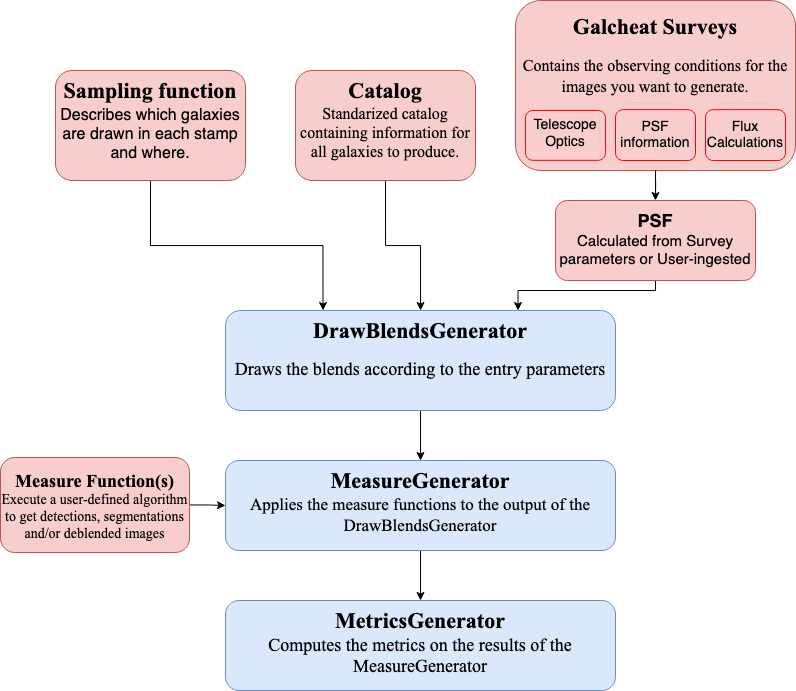

Because this notebook is focused on just creating our dataset of 2 components i.e.:
1. Blended image with noise (i.e. what the telescope sees)
2. Individual sources that make up the blend with no noise (i.e. what the truth image is)

We'll be focusing on just the first blue box. This is the generator that **creates** the blends and the individual galaxies we'll be using for training our model. As can be seen from the diagram there are 4 inputs to the generator that we need to set/implement before we are able to start creating our dataset.

# 1. Catalog

We first **"Load Catalog"**. We read in the input catalog file. This must be done using a `Catalog`-like object, either by providing directly the catalog or by using the `from_file()` method. (We use the `from_file()` method below).

I'm using the CatSim catalog corresponding to one square degree of sky.

In [2]:
# Catalog:
#---------#
catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/DS_creation/Data/OneDegSq.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

# 2. Sampling Function

We first **set parameter values**:

We define the parameter values to create postage stamps, including:
- Size of stamp.
- Number of objects per blend.
- How many stamps are to be drawn in one batch -i.e., the number of stamps BTK will produce together in a single batch.

Next, we **specify the `SamplingFunction`**:

A sampling function is a callable object, which takes the `Catalog.table` as input and returns modified selected entries corresponding to the galaxies being drawn. You can use the default class `DefaultSamplingFunction`, or define a new one if you want to have more control over how the galaxies are selected and the blends are defined.

**NOTE:** The default sampling function performs a cut of `ref_mag < 25.3` (ie. select objects brighter than 25.3 mag)

In [3]:
# Setting parameter values:
#-------------------#
stamp_size = 24.0 # Size of the stamp, in arcseconds
max_number = 3 # Max number of galaxies in a blend
max_shift = 3.0 # Max shift of the galaxies from center, in arcseconds

# Sampling Function:
#-------------------#
sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number,
                                                          stamp_size=stamp_size,
                                                          maxshift=max_shift)

# 3. Survey

We **choose a survey:**

BTK relies on the [galcheat](https://github.com/aboucaud/galcheat) package. This package contains information on various surveys, including LSST, HSC, Euclid, DES, and CFHT. It provides `Survey` object, which can be  easily imported into BTK using its name via the `get_surveys()` function e.g. `btk.survey.get_surveys(survey_names)`. It's also pretty simple to tweak the parameters of the survey at this stage. The user can also provide a custom PSF at this point, either as a Galsim model or with a FITS file (or use the default PSF provided by BTK).

In [4]:
# Survey
#-------#
LSST = btk.survey.get_surveys("LSST")

# 4. Draw Blends/Dataset Creation

Now that we've created/set all of the necessary inputs we are ready to **draw blends**:

We do this by simulating scenes of overlapping objects, convolved by the PSF and with pixel noise. This is done by creating a `DrawBlendsGenerator`-like object, which is given the catalog, sampling function, and survey created in steps 1-3. It is called by using `next(draw_blends_generator)` where the results are a dictionary that includes:
- The blends via the key `blend_images`.
- The isolated galaxy imagees via the key `isolated_images`.
- The blend parameters via the key `blend_list`.

In the case where multiple surveys were provided in step 3, each entry will instead take the form of a dictionary indexed by the survey names, with each value corresponding to the information for one of the surveys (e.g. `batch['blend_images']['LSST']`)

Fluxes in BTK are calculated using [galcheat][https://aboucaud.github.io/galcheat/api/utilities.html] based on the function `galcheat.utilities.mag2counts` function and corresponing survey and filter parameters.

In [5]:
# Draw Blends:
#-------------#
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog=catalog,
    sampling_function=sampling_function,
    surveys=LSST,
    batch_size=10,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all", 
    seed=1)

The results from the `next` call are stored in a dictionary; the keys are:

- `blend_images`: for the actual images (as a np.array of shape `(batch_size, stamp_size, stamp_size, len(survey.filters))`
- `isolated_images`: for the isolated images (as a np.array of shape `(batch_size, sampling_function.max_number, stamp_size, stamp_size, len(survey.filters))`
- `blend_list`: for the blend information (as a list of astropy tables corresponding to the output of the sampling function for each blend)
- `psf` for the PSF (as a list of Galsim objects)
- `wcs` for the World Coordinate System corresponding to the images (as a list of `astropy.wcs.WCS` objects)


In [6]:
batch = next(draw_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list']
isolated_images = batch['isolated_images']

indx = 0    # Sample number
cindx = 2   # Channel index (band number has 6 filters for LSST)
oindx = 0   # Object index (for the isolated images)

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
def iso_blended_plot(blend_images, isolated_images, indx, limits=(30,90)):
    """
    Function to plot the blended image and its constituent isolated
    galaxies in 3 LSST bands (gri) and a sum of all 6 bands.
    
    Args:
    -----
        blend_images: np.array
            The actual blended image with all the noise, as seen from the telescope.
        isolated_images: np.array
            The individual images that make-up the blend_images. These are noise free.
        indx: int
            The index of the sample to plot.
        limits: 
            
    Returns:
    --------
        matplotlib.imshow plot of the blended scene and its isolated galaxies
        in the 3 LSST filters (gri) and a sum of all the 6 bands.
    """
    # Number of galaxies in blend
    num_of_obj = isolated_images.shape[1] 
    
    # Creating the 3 band blend img & the 6-band summed blend img
    avg_blend_img = np.sum(blend_images[indx, :, :, :], axis=0)
    blend_3band = btk.plot_utils.get_rgb_image(blend_images[indx])
    
   
    fig, axes = plt.subplots(2, num_of_obj+1, figsize=(30,26))
    for i in range(num_of_obj+1):
        # First row of images will be the blended image in gri bands
        # and the sum over all bands
        axes[0,0].imshow(blend_3band)
        axes[0,0].set_xlim(limits)
        axes[0,0].set_ylim(limits)
        axes[0,0].axis('off')
        axes[0,0].set_title('Blend: gri bands', fontsize=30)
        axes[1,0].imshow(avg_blend_img)
        axes[1,0].set_xlim(limits)
        axes[1,0].set_ylim(limits)
        axes[1,0].axis('off')
        axes[1,0].set_title('Blend: Sum over bands', fontsize=30)

        # Create as many gri/sum over all band images for the
        # individual galaxies that make up the blended image.
        axes[0,i].imshow(btk.plot_utils.get_rgb_image(isolated_images[indx][i-1]))
        axes[0,i].set_xlim(limits) # set_xlim flips the axeses
        axes[0,i].set_ylim(limits)
        axes[0,i].axis('off')
        axes[0,i].set_title(f'Iso {i}: gri bands', fontsize=30)
        axes[1,i].imshow(np.sum(isolated_images[indx][i-1][:, :, :], axis=0))
        axes[1,i].set_xlim(limits)
        axes[1,i].set_ylim(limits)
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Iso {i}: Sum over bands', fontsize=30)
        
    plt.tight_layout()
    plt.show()

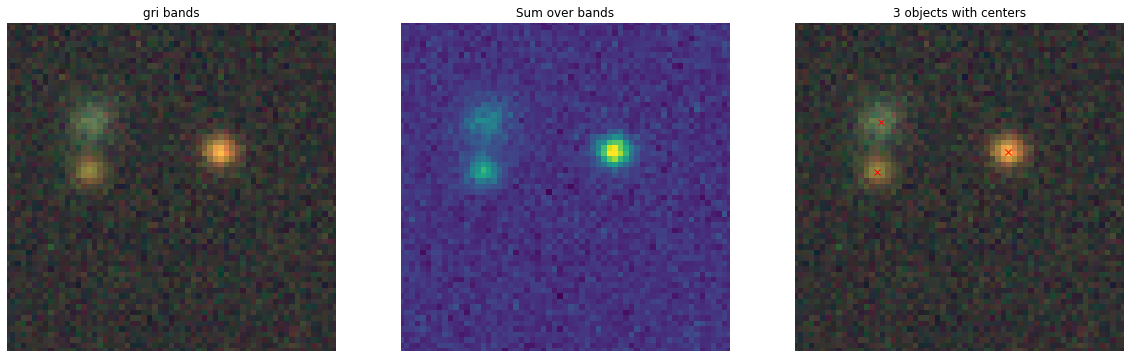

In [8]:
btk.plot_utils.plot_blends(blend_images[indx:indx+1],
                           blend_list[indx:indx+1],
                           limits=(30,90))

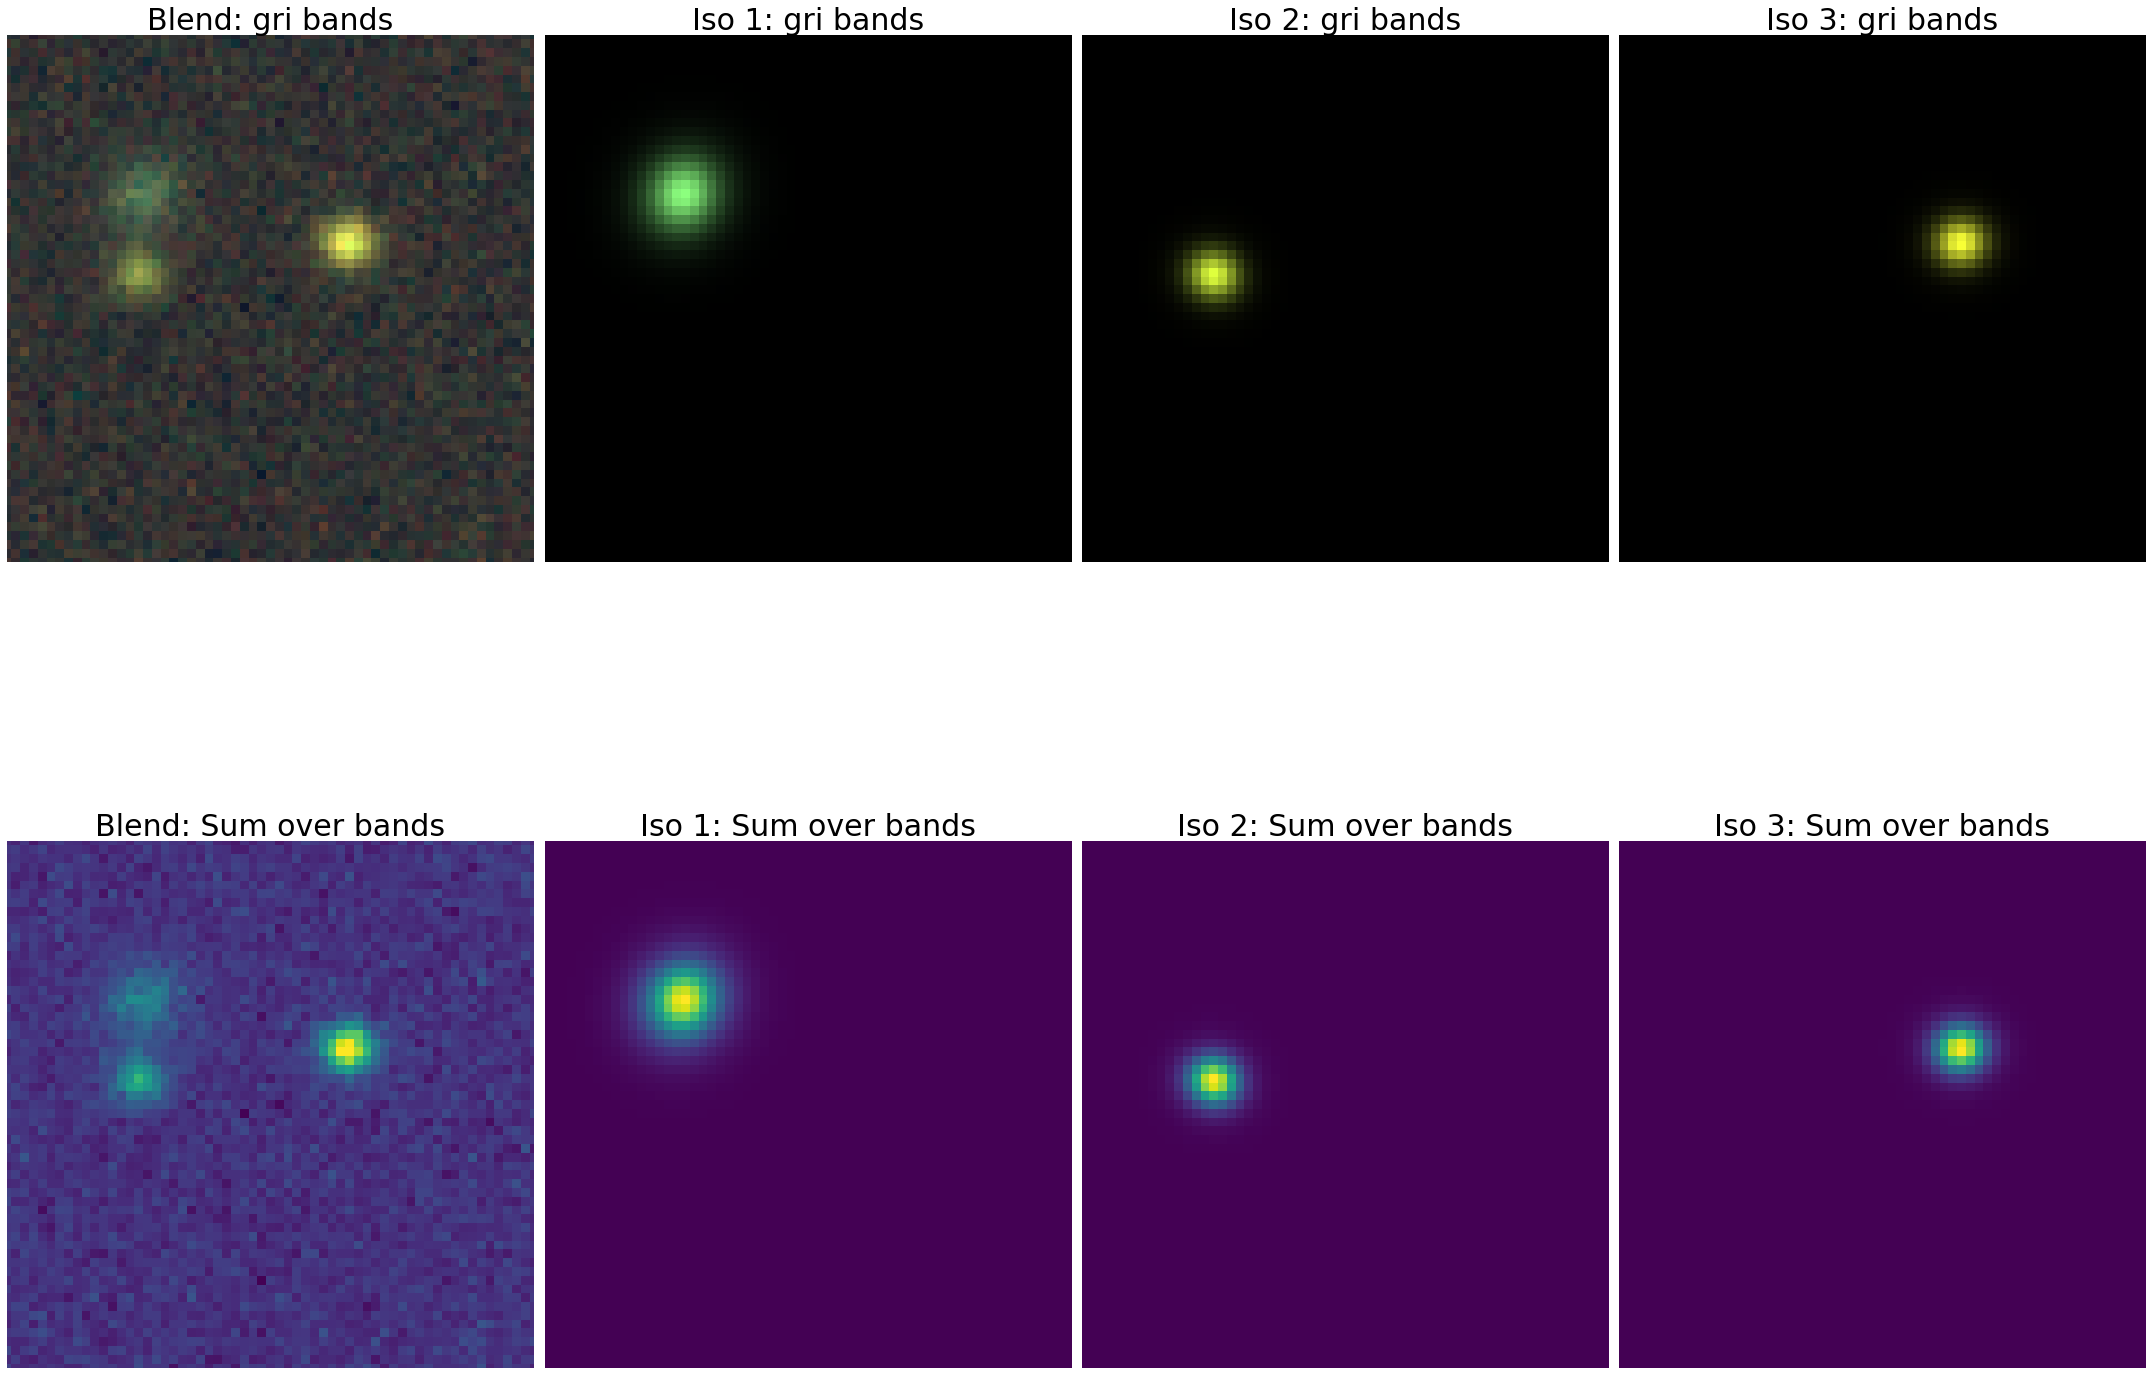

In [9]:
iso_blended_plot(blend_images=blend_images,
                 isolated_images=isolated_images,
                 indx=indx,
                 limits=(30,90))

I'm not sure why the blended plots look different. My version of thee function `btk.plot_utils.get_rgb_image` is different than the one on [github](https://github.com/LSSTDESC/BlendingToolKit/blob/main/btk/plot_utils.py). I'm wondering if that  will cause any problems?

Also, the reason for the difference in color is probably down to me missing something that is crucial in `btk.plot_utils.plot_blends` that I've not implemented in my own plotting function.

**NOTE:** When using my own function `iso_blend_plot` when I change the `indx` to a value that is different I run into an error and I'm not sure why that is the case. An example is below.

*The error is saying that the max/min values must not be equal when using `btk.plot_utils.get_rgb_image`, but I thought I was not using the `Scarlet` package, so I'm unsure of why it using that setting of the function.*

ValueError: minimum and maximum values must not be equal

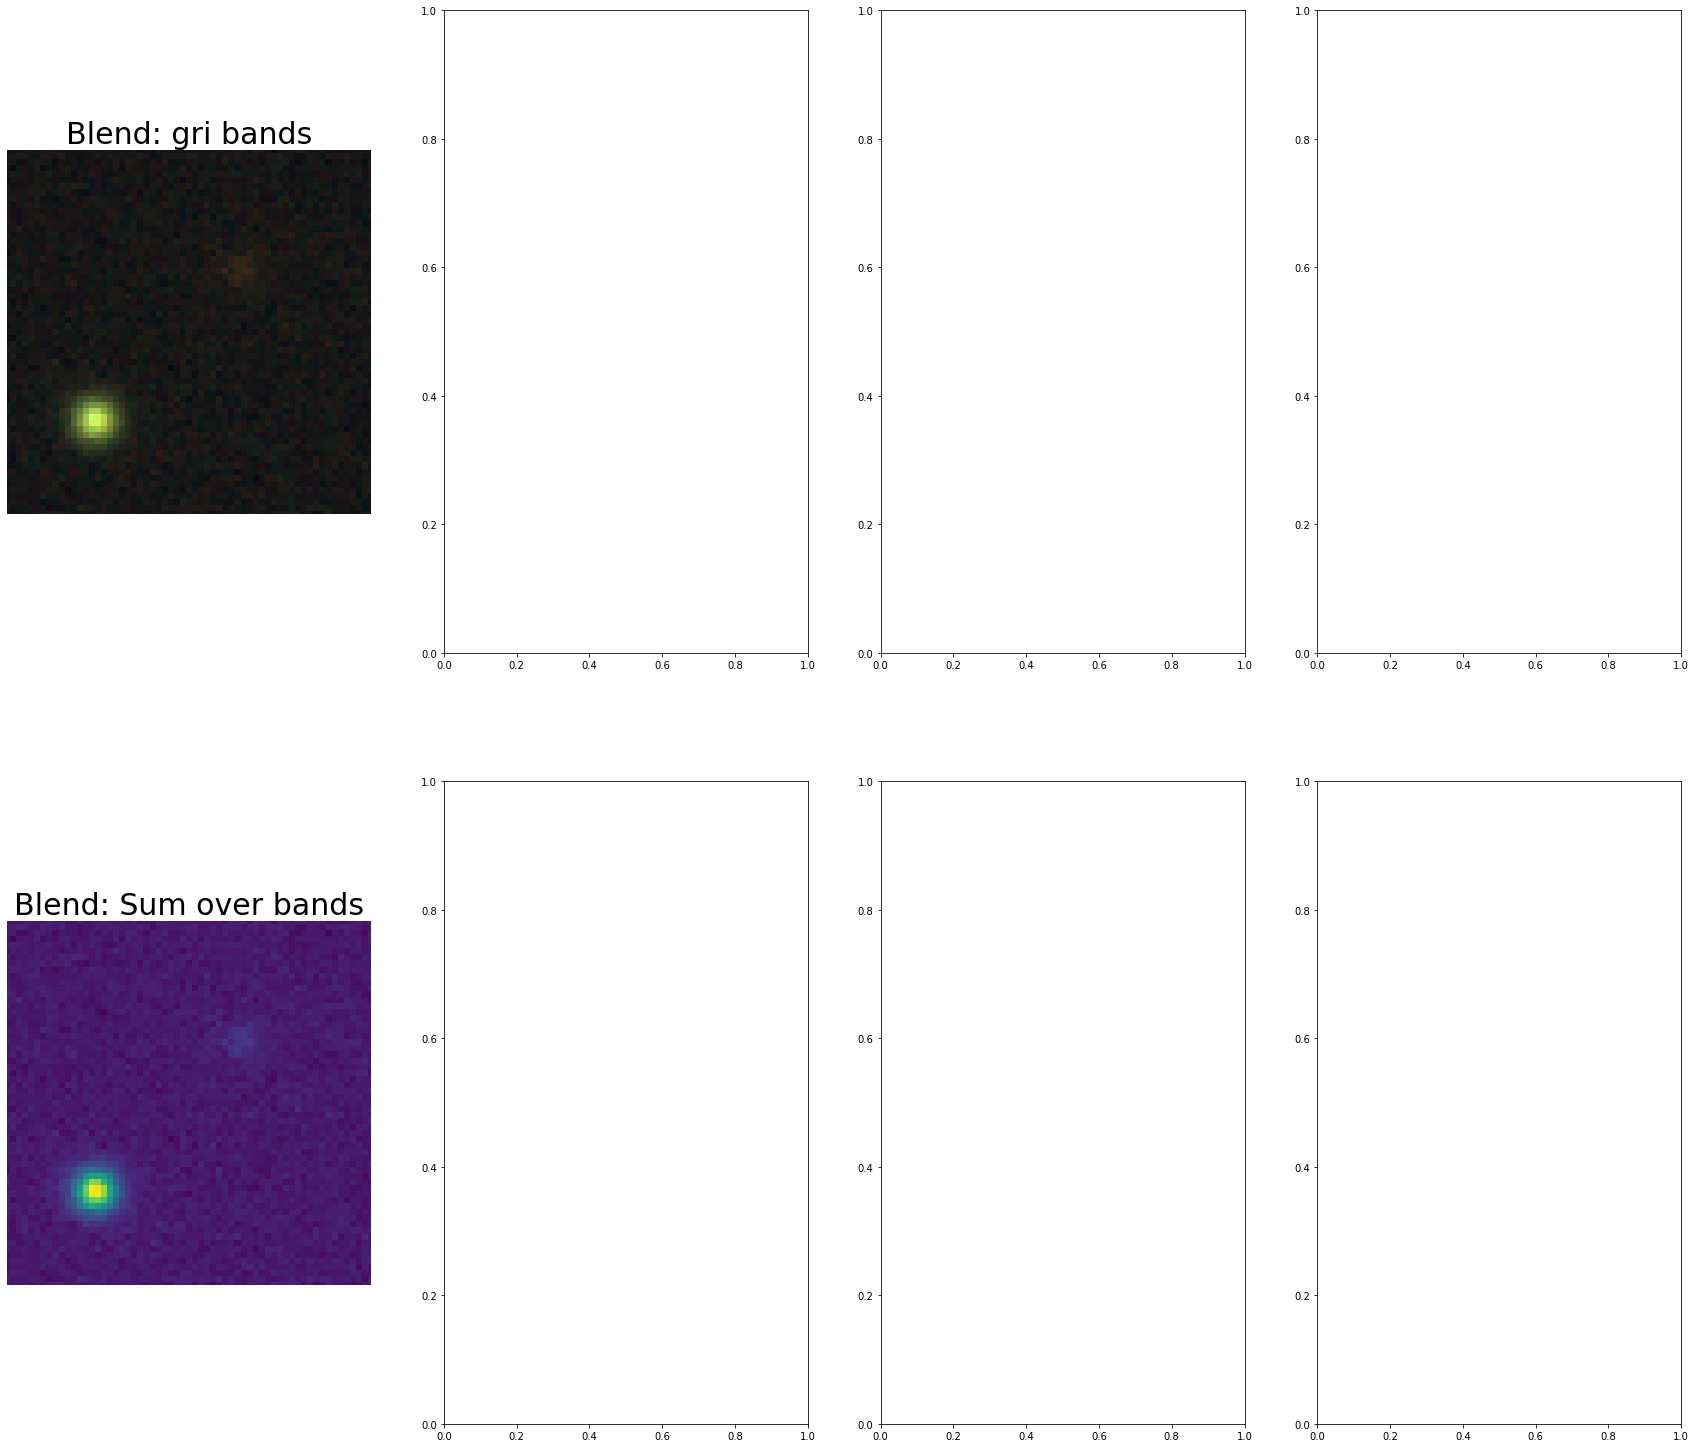

In [10]:
iso_blended_plot(blend_images=blend_images,
                 isolated_images=isolated_images,
                 indx=indx+1,
                 limits=(30,90))

Here is a BTK function that is similar to what I'm trying to plot.

In [ ]:
btk.plot_utils.plot_with_isolated(blend_images=blend_images,
                                   isolated_images=isolated_images,
                                   blend_list=blend_list)